In [2]:
def AverageFluxInFilter(spectrum_wavelength, spectrum_flux, filter_wavelength, filter_transmission):
    from scipy.interpolate import interp1d
    import numpy as np
    ### We need to interpolate the spectrum's flux array onto the filter's wavelength array 
    # so they can be multiplied:
    # First cut off areas of spectrum outside the filter curve to avoid interpolation errors:
    ind = np.where((spectrum_wavelength > np.min(filter_wavelength)) &
                   (spectrum_wavelength < np.max(filter_wavelength)))[0]
    # Make interpolation function:
    interpfunc = interp1d(spectrum_wavelength[ind],spectrum_flux[ind], fill_value="extrapolate")
    # interpolate the spectrum's flux on the filter's wavelength array:
    flux_on_filter_wavelength_grid = interpfunc(filter_wavelength)
    # Multiply flux by filter transmission:
    filter_times_flux = flux_on_filter_wavelength_grid * filter_transmission

    # compute dlambda
    dl = np.mean([filter_wavelength[i] - filter_wavelength[i-1] for i in range(1,len(filter_wavelength))])

    # Compute weighted average:
    filter_weighted_average = np.sum(filter_times_flux * filter_wavelength * dl) / \
            np.sum(filter_transmission * filter_wavelength * dl)
    return filter_weighted_average

vega = pd.read_csv('/Users/loganpearce/Dropbox/astro_packages/myastrotools/myastrotools/vega.csv')
import pickle

pickles = pickle.load(open('pickle_models.pkl','rb'))
spts = [key for key in pickles.keys()]

In [3]:
import pandas as pd
# Get MagAOX filter curves:
directory = '/Users/loganpearce/Dropbox/Uarizona/research/filter_curves/'
#magaox_sci2-gp_bs-65-35_scibs-5050.dat
file = 'magaox_sci1-zp_bs-65-35_scibs-5050.dat'
zfilter = pd.read_table(directory+file, comment='#', 
                  names=['wavelength [m]','transmission'], delim_whitespace=True)
zfilter['normalized transmission'] = zfilter['transmission']/np.max(zfilter['transmission'])

file = 'magaox_sci2-ip_bs-65-35_scibs-5050.dat'
ifilter = pd.read_table(directory+file, comment='#', 
                  names=['wavelength [m]','transmission'], delim_whitespace=True)
ifilter['normalized transmission'] = ifilter['transmission']/np.max(ifilter['transmission'])

file = 'magaox_sci1-rp_bs-65-35_scibs-5050.dat'
rfilter = pd.read_table(directory+file, comment='#', 
                  names=['wavelength [m]','transmission'], delim_whitespace=True)
rfilter['normalized transmission'] = rfilter['transmission']/np.max(rfilter['transmission'])

file = 'magaox_sci2-gp_bs-65-35_scibs-5050.dat'
gfilter = pd.read_table(directory+file, comment='#', 
                  names=['wavelength [m]','transmission'], delim_whitespace=True)
gfilter['normalized transmission'] = gfilter['transmission']/np.max(gfilter['transmission'])
MagAOXfilters = [zfilter, ifilter, rfilter, gfilter]

In [6]:
f6535 = pd.read_table('magaox_wfs-open_bs-65-35_atm.dat', comment='#', 
                  names=['wavelength [m]','transmission'], delim_whitespace=True)
f6535['wavelength [nm]'] = f6535['wavelength [m]']*u.m.to(u.nm)
f6535['normalized transmission'] = f6535['transmission']/np.max(f6535['transmission'])

fhair = pd.read_table('magaox_wfs-open_bs-halpha-ir.dat', comment='#', 
                  names=['wavelength [m]','transmission'], delim_whitespace=True)
fhair['wavelength [nm]'] = fhair['wavelength [m]']*u.m.to(u.nm)
fhair['normalized transmission'] = fhair['transmission']/np.max(fhair['transmission'])

g = pd.read_table(directory+'GaiaEDR3_passbands_zeropoints_version2/passband.dat', comment='#', 
                  names=['wavelength [nm]','G','eG','BP','eBP','RP','eRP'], delim_whitespace=True)
ind = g.loc[np.where(g['BP']==99.99)[0]]
g['BP'].loc[np.where(g['BP']==99.99)[0]] = 0
g['RP'].loc[np.where(g['RP']==99.99)[0]] = 0
g['G'].loc[np.where(g['G']==99.99)[0]] = 0
g['BP'] = g['BP']/max(g['BP'])
g['RP'] = g['RP']/max(g['RP'])
g['G'] = g['G']/max(g['G'])

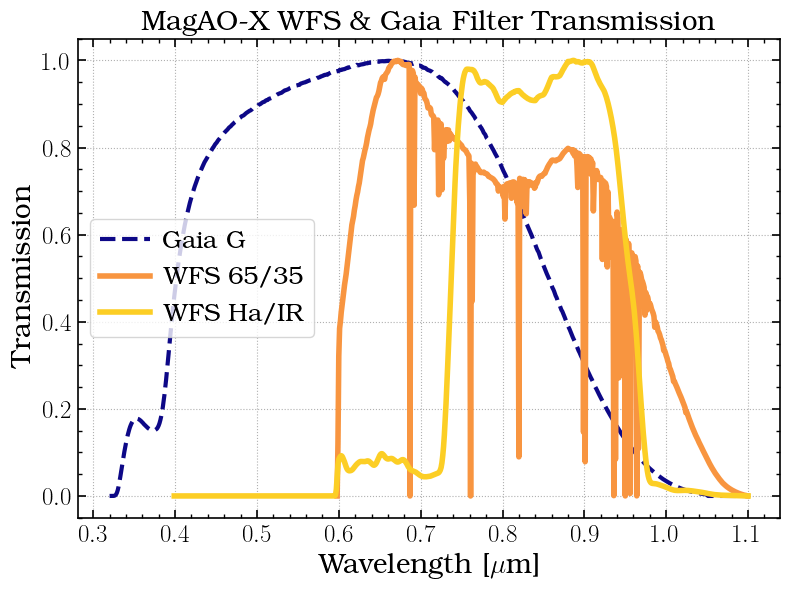

In [28]:
%matplotlib inline
import matplotlib
cmap = matplotlib.colormaps.get_cmap('plasma')
colors = cmap(np.linspace(0,0.9,7))
plt.style.use('erid')
plt.plot(g['wavelength [nm]']*u.nm.to(u.um),g['G'],label='Gaia G', color = colors[0], ls='--')
# plt.plot(g['wavelength [nm]']*u.nm.to(u.um),g['BP'],label='Gaia BP', color = colors[1], ls='--')
# plt.plot(g['wavelength [nm]']*u.nm.to(u.um),g['RP'],label='Gaia RP', color = colors[2], ls='--')

plt.plot(f6535['wavelength [m]']*u.m.to(u.um),f6535['normalized transmission'],lw=4,label='WFS 65/35',
        color = colors[-2])
plt.plot(fhair['wavelength [m]']*u.m.to(u.um),fhair['normalized transmission'],lw=4,label='WFS Ha/IR',
        color = colors[-1])

plt.legend(fontsize=15,loc='upper left')
plt.tight_layout()
plt.grid(ls=':')
plt.xlabel('Wavelength [$\mu$m]')
plt.ylabel('Transmission')
plt.grid(ls=':')
plt.legend()
plt.title('MagAO-X WFS \& Gaia Filter Transmission')
plt.tight_layout()
plt.savefig('WFS-Gaia-curves.png', bbox_inches = 'tight')

In [16]:
def GetColorWAvgFilterMethod(spectrum_wavelength, spectrum_flux,
                           filt1_wavelength, filt1_transmission, 
                           filt2_wavelength, filt2_transmission,
#                            filt1_sdss = False, filt2_sdss = False,
#                            filt1_name = 'None', filt2_name = 'None'
                            ):
    
    modelfilt1 = AverageFluxInFilter(spectrum_wavelength, 
                                     spectrum_flux, 
                                filt1_wavelength,
                               filt1_transmission)
    modelfilt2 = AverageFluxInFilter(spectrum_wavelength, spectrum_flux, 
                                filt2_wavelength,
                               filt2_transmission)
    #file = os.path.join(os.path.dirname(__file__), 'vega.csv')
    file = '/Users/loganpearce/Dropbox/astro_packages/myastrotools/myastrotools/vega.csv'
    vega = pd.read_csv(file)
    
    vegafilt1 = AverageFluxInFilter(vega['WAVELENGTH [um]'],vega['FLUX'],
                                  filt1_wavelength,
                                   filt1_transmission)
    vegafilt2 = AverageFluxInFilter(vega['WAVELENGTH [um]'],vega['FLUX'],
                                      filt2_wavelength,
                                       filt2_transmission)
    #VegaToAB = {'z':0.54, 'i':0.37, 'r':0.16, 'g':-0.08}
    filt1mag = -2.5*np.log10(modelfilt1/vegafilt1)
    filt2mag = -2.5*np.log10(modelfilt2/vegafilt2)
#     if filt1_sdss:
#         filt1mag = filt1mag + VegaToAB[filt1_name]
#     if filt2_sdss:
#         filt2mag = filt2mag + VegaToAB[filt2_name] 
    return filt1mag - filt2mag

        

In [18]:
p = pd.DataFrame()
p['SpT'] = spts

dwarfs = [key for key in spts if 'V' in key]
giants = [key for key in spts if 'V' not in key]

spt_letter_conv = {'O':0,'B':1,'A':2,'F':3,'G':4,'K':5,'M':6}

spt_numbers = np.array([])
for s in spts:

    letter = s[0]
    number = spt_letter_conv[letter]
    
    type_number = float(s[1]) / 10
    
    spt_numbers = np.append(spt_numbers,number + type_number)
    
spt_numbers[-1] = 7.0
spt_numbers[5] = 1.6
spt_numbers_dwarfs = spt_numbers[range(len(dwarfs))]
spt_numbers_giants = spt_numbers[range(len(dwarfs),len(spt_numbers))]
spt_numbers_dwarfs,spt_numbers_giants
p['SpT numbers'] = spt_numbers

p['G - 65/35 color'], p['G - Ha/IR color'], p['Gaia BP-RP'] = np.nan,np.nan,np.nan
p

,SpT,SpT numbers,G - 65/35 color,G - Ha/IR color,Gaia BP-RP
0,O5V,0.5,NaN,NaN,NaN
1,O9V,0.9,NaN,NaN,NaN
2,B0V,1.0,NaN,NaN,NaN
3,B1V,1.1,NaN,NaN,NaN
4,B3V,1.3,NaN,NaN,NaN
...,...,...,...,...,...
63,M6III,6.6,NaN,NaN,NaN
64,M7III,6.7,NaN,NaN,NaN
65,M8III,6.8,NaN,NaN,NaN
66,M9III,6.9,NaN,NaN,NaN


In [20]:

import warnings
warnings.filterwarnings('ignore')

Gaia_filternames = ['G','BP','RP']
MagAOX_filternames = ['65/35','HaIR']

for i,spt in enumerate(spts):
    avecolor = GetColorWAvgFilterMethod(pickles[spt]['wavelength']*u.AA.to(u.um), pickles[spt]['flux'], 
                       g['wavelength [nm]']*u.nm.to(u.um),g['G'],
                    f6535['wavelength [m]']*u.m.to(u.um),f6535['normalized transmission'])
    p['G - 65/35 color'][i] = avecolor
    avecolor = GetColorWAvgFilterMethod(pickles[spt]['wavelength']*u.AA.to(u.um), pickles[spt]['flux'], 
                       g['wavelength [nm]']*u.nm.to(u.um),g['G'],
                    fhair['wavelength [m]']*u.m.to(u.um),fhair['normalized transmission'])
    p['G - Ha/IR color'][i] = avecolor
    avecolor = GetColorWAvgFilterMethod(pickles[spt]['wavelength']*u.AA.to(u.um), pickles[spt]['flux'], 
                       g['wavelength [nm]']*u.nm.to(u.um),g['BP'],
                    g['wavelength [nm]']*u.nm.to(u.um),g['RP'])
    p['Gaia BP-RP'][i] = avecolor


In [21]:
dwarfs = [i for i in p['SpT'] if 'V' in i]
giants = [i for i in p['SpT'] if 'III' in i]

dwarfs_colors = [p['G - 65/35 color'][i] for i in range(len(dwarfs))]
giants_colors = [p['G - 65/35 color'][i] for i in range(len(dwarfs),len(p))]
dwarfs_gaia_colors = [p['Gaia BP-RP'][i] for i in range(len(dwarfs))]
giants_gaia_colors = [p['Gaia BP-RP'][i] for i in range(len(dwarfs),len(p))]

dwarfs_colors2 = [p['G - Ha/IR color'][i] for i in range(len(dwarfs))]
giants_colors2 = [p['G - Ha/IR color'][i] for i in range(len(dwarfs),len(p))]

In [23]:
#directory = '/Users/loganpearce/Dropbox/Uarizona/research/MagAO-X_public/MagAO-X-color-conversions/'
p.to_csv('GaiaG_WFS_color_conversion.csv',index=False)
#p.to_csv(directory+'GaiaG_WFS_color_conversion.csv',index=False)
p

,SpT,SpT numbers,G - 65/35 color,G - Ha/IR color,Gaia BP-RP
0,O5V,0.5,-0.357350,-0.449189,-0.544758
1,O9V,0.9,-0.345221,-0.431679,-0.518311
2,B0V,1.0,-0.311909,-0.381367,-0.474029
3,B1V,1.1,-0.223228,-0.272449,-0.349441
4,B3V,1.3,-0.160505,-0.188181,-0.244123
...,...,...,...,...,...
63,M6III,6.6,1.457540,1.907618,3.450804
64,M7III,6.7,1.650735,2.083696,4.108393
65,M8III,6.8,1.866496,2.201543,4.581751
66,M9III,6.9,1.860012,2.176054,4.396920


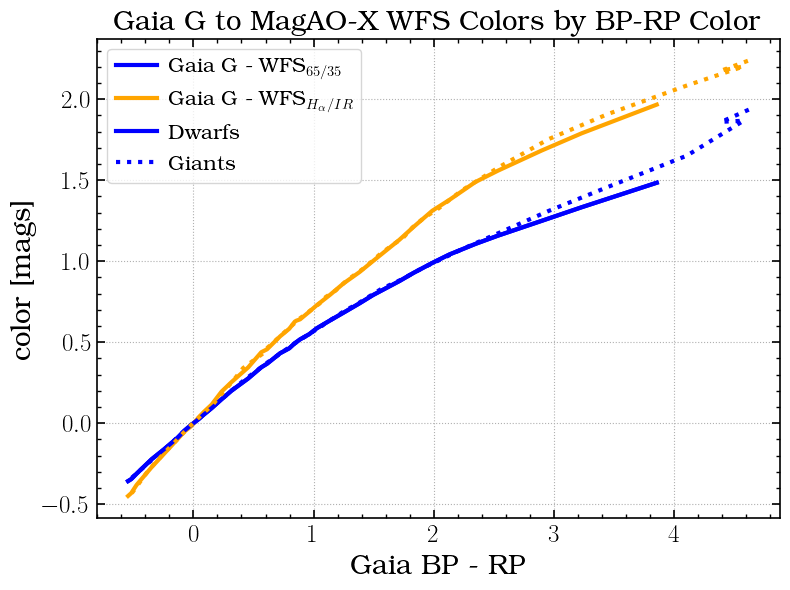

In [26]:
%matplotlib inline
c=['blue','orange']
plt.plot(dwarfs_gaia_colors,dwarfs_colors, color=c[0],label=r'Gaia G - WFS$_{65/35}$')
plt.plot(dwarfs_gaia_colors,dwarfs_colors2,color=c[1],label=r'Gaia G - WFS$_{H_\alpha/IR}$')

plt.plot(dwarfs_gaia_colors,dwarfs_colors, color=c[0],label=r'Dwarfs')
plt.plot(giants_gaia_colors,giants_colors, color=c[0], ls=':',label=r'Giants')
plt.plot(giants_gaia_colors,giants_colors2,color=c[1], ls=':')

plt.ylabel('color [mags]')
plt.xlabel('Gaia BP - RP')
plt.legend(fontsize=15)

plt.title('Gaia G to MagAO-X WFS Colors by BP-RP Color')
plt.tight_layout()
plt.grid(ls=':')
plt.savefig('GaiaG_to_MagAO-X_WFS_color_conversion-ByBPRPcolor.png',dpi=300)
plt.savefig(directory+'GaiaG_to_MagAO-X_WFS_color_conversion-ByBPRPcolor.png',dpi=300)
plt.show()

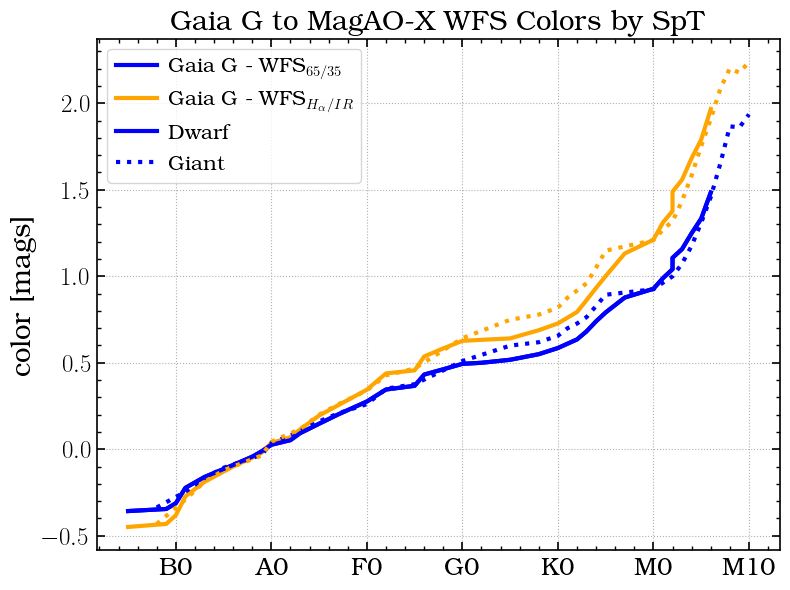

In [27]:
%matplotlib inline
c=['blue','orange']
plt.plot(spt_numbers_dwarfs,dwarfs_colors,color=c[0],label='Gaia G - WFS$_{65/35}$')
plt.plot(spt_numbers_dwarfs,dwarfs_colors2,color=c[1],label=r'Gaia G - WFS$_{H_\alpha/IR}$')

plt.plot(spt_numbers_dwarfs,dwarfs_colors,color=c[0],label='Dwarf')
plt.plot(spt_numbers_giants,giants_colors,color=c[0],ls=':',label = 'Giant')
plt.plot(spt_numbers_giants,giants_colors2,color=c[1],ls=':')

#plt.ylim(-2.7,1)
ticks = np.arange(1,7.5,1)
labels = ['B0','A0','F0','G0','K0','M0','M10']
plt.gca().set_xticks(ticks)
plt.gca().set_xticklabels(labels)
plt.ylabel('color [mags]')
plt.legend(fontsize=15)

plt.title('Gaia G to MagAO-X WFS Colors by SpT')

plt.tight_layout()
plt.grid(ls=':')
plt.savefig('GaiaG_to_MagAO-X_WFS_color_conversion.png',dpi=300)
plt.savefig(directory+'GaiaG_to_MagAO-X_WFS_color_conversion.png',dpi=300)
plt.show()